In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import nltk
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
#from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



In [4]:
df = pd.read_csv('C:\\Users\\zba19\\Documents\\Python Scripts\\nlp\\amazon\\Reviews.csv')

In [5]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
df.shape

(568454, 10)

In [7]:
df = df.sample(frac= 0.20,replace = True).reset_index(drop = True)

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,155390,B000GAT6NG,A2CDE4KP3M7J94,"Debbrin K. Lecki ""DKL""",0,0,5,1200873600,"Awesome, Multi Use Product!",I purchased this product. I use it for everyth...
1,108518,B0030VBQGS,A25LXMUA6IK2W9,Sara Ledford,0,0,5,1318809600,Yummy,"This is excellent, especially to mix with baby..."
2,307510,B0092X7IY2,A2DJFN6DQQ8WF9,"E. Carr ""tinkerbelle""",0,0,5,1244937600,Jelly Belly,Just because I sent an order of these jelly be...
3,467464,B001CWU9HE,A6TOGEJT5XSCI,Grace Blue Jay,0,0,4,1293494400,Great Crackers!,Glutino Gluten Free Cheddar Crackers are so go...
4,467357,B001EO5JUC,A2VVTW43ZXVO7Y,"Richard E. Luke ""Dick Luke""",0,0,5,1234137600,Healthy breakfast cereal,I discovered this cereal while in Ireland last...


In [8]:
df.shape

(113691, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113691 entries, 0 to 113690
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      113691 non-null  int64 
 1   ProductId               113691 non-null  object
 2   UserId                  113691 non-null  object
 3   ProfileName             113685 non-null  object
 4   HelpfulnessNumerator    113691 non-null  int64 
 5   HelpfulnessDenominator  113691 non-null  int64 
 6   Score                   113691 non-null  int64 
 7   Time                    113691 non-null  int64 
 8   Summary                 113682 non-null  object
 9   Text                    113691 non-null  object
dtypes: int64(5), object(5)
memory usage: 8.7+ MB


In [10]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               6
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   9
Text                      0
dtype: int64

In [11]:
df.dropna(inplace= True)

In [12]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

What is the distribution of ratings across dataset

In [13]:
rating_pct = df['Score'].value_counts()/len(df) * 100
rating_pct

5    63.922024
4    14.135789
1     9.125937
3     7.584714
2     5.231535
Name: Score, dtype: float64

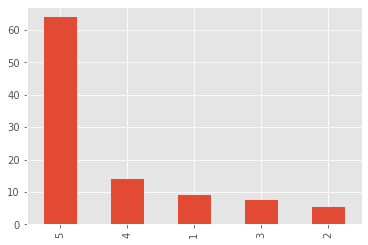

In [14]:
rating_pct.plot.bar()
plt.show()

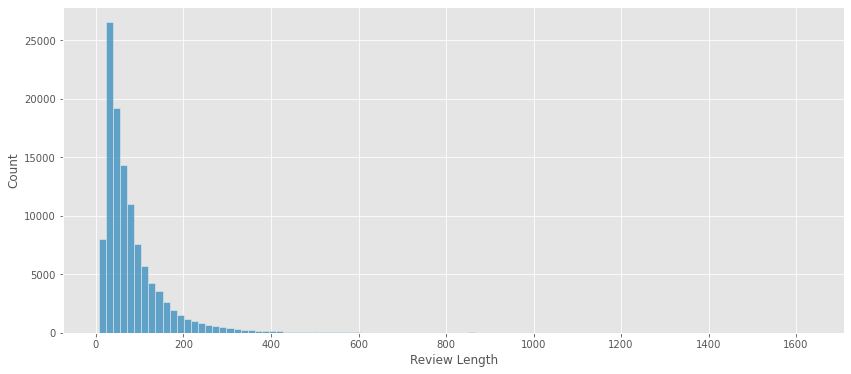

In [15]:
#words per review
plt.figure(figsize = (14,6))
WordsPerReview = df['Text'].apply(lambda x: len(x.split(' ')))

sns.histplot(WordsPerReview,bins = 100)

plt.xlabel('Review Length')
plt.show()

#### Word cloud

In [ ]:
txt = ' '.join(review for review in df.Text)

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Data Preprocessing and Transformation

In [16]:
df = pd.DataFrame(df,columns = ['Score','Text'])
df.rename(columns = {'Score':'Rating','Text':'Review'},inplace = True)

In [17]:
def apply_sentiment(Rating):
    if(Rating <=2 ):
        return 0
    else:
        return 1

In [18]:
df['Sentiment'] = df['Rating'].apply(apply_sentiment)
df.drop(['Rating'],axis = 1, inplace = True)

In [19]:
sentiment = df['Sentiment'].value_counts()
sentiment

1    97355
0    16321
Name: Sentiment, dtype: int64

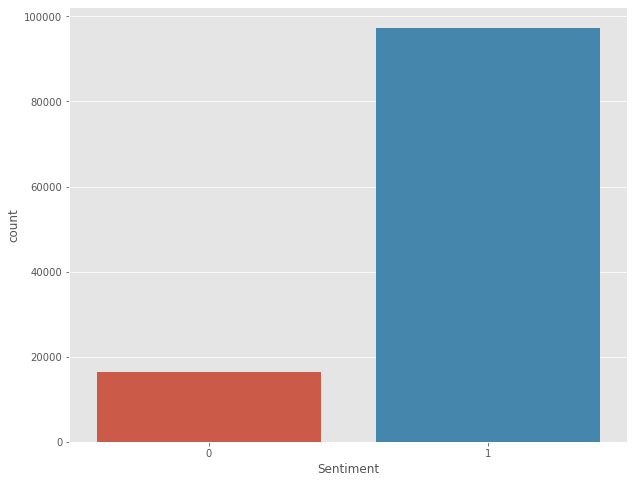

In [20]:
plt.figure(figsize = ( 10,8))
sns.countplot(data = df, x = 'Sentiment')
plt.show()

In [21]:
def clean_text(Review):
   
    Review = str(Review).lower() # convert to lowercase
    Review = re.sub('\[.*?\]', '', Review) 
    Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
    Review = re.sub('<.*?>+', '', Review)
    Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review


In [22]:
df['Review'] = df['Review'].apply(clean_text)

In [23]:
df.head()

,Review,Sentiment
0,i purchased this product i use it for everythi...,1
1,this is excellent especially to mix with baby ...,1
2,just because i sent an order of these jelly be...,1
3,glutino gluten free cheddar crackers are so go...,1
4,i discovered this cereal while in ireland last...,1


In [26]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stopword = []
sentence = df['Review'][0]


#words = nltk.word_tokenize(sentence)


def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

df['reviews_text'] = df['Review'].apply(lambda row: remove_stopword(stop_words, row))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zba19\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zba19\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [27]:
df.head(3)

,Review,Sentiment,reviews_text
0,i purchased this product i use it for everythi...,1,"[purchased, product, use, everything, cooking,..."
1,this is excellent especially to mix with baby ...,1,"[excellent, especially, mix, baby, cereal, mak..."
2,just because i sent an order of these jelly be...,1,"[sent, order, jelly, beansto, oldest, son, ros..."


In [29]:
X=df["reviews_text"]
y=df["Sentiment"]

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((90940,), (22736,), (90940,))

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

In [32]:
fit_model = clf.fit(X_train,y_train)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print('Training accuracy:', fit_model.score(X_train,y_train))
print('Test accuracy:', fit_model.score(X_test,y_test))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))